# Imports

In [230]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.linalg import svd
import time

# Code

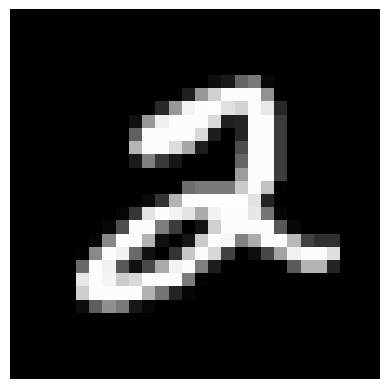

In [131]:
# Load images from the MNIST dataset
def load_image_file(filename):
    with open(filename, 'rb') as f:
        # Skip the magic number and number of images
        _, num_images = struct.unpack(">II", f.read(8))
        rows, cols = struct.unpack(">II", f.read(8))  # Image dimensions
        # Read image data and reshape into (num_images, rows*cols)
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)
    return {'n': num_images, 'x': images}

# Load labels from the MNIST dataset
def load_label_file(filename):
    with open(filename, 'rb') as f:
        # Skip the magic number and number of labels
        _, num_labels = struct.unpack(">II", f.read(8))
        # Read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Load training and test datasets
def load_mnist():
    train = load_image_file('/Users/TomiTian/Downloads/train-images-idx3-ubyte')
    test = load_image_file('/Users/TomiTian/Downloads/t10k-images-idx3-ubyte')
    
    train['y'] = load_label_file('/Users/TomiTian/Downloads/train-labels-idx1-ubyte')
    test['y'] = load_label_file('/Users/TomiTian/Downloads/t10k-labels-idx1-ubyte')
    
    return train, test

# Display an MNIST digit image
def show_digit(arr784):
    plt.imshow(arr784.reshape(28, 28), cmap='gray')
    plt.axis('off')  # Hide axes for cleaner display
    plt.show()

# Load MNIST data
train, test = load_mnist()

# Display an example image (e.g., the 5th training image)
show_digit(train['x'][5])


In [228]:
image

NameError: name 'image' is not defined

In [122]:
test_labels = load_label_file('/Users/TomiTian/Downloads/t10k-labels-idx1-ubyte')
test_images = load_image_file('/Users/TomiTian/Downloads/t10k-images-idx3-ubyte')

print(f"Number of test labels: {len(test_labels)}")
print(f"Number of test images: {len(test_images)}")

print(test_labels)

Number of test labels: 10000
Number of test images: 2
[7 2 1 ... 4 5 6]


In [137]:
train_labels = load_label_file('/Users/TomiTian/Downloads/train-labels-idx1-ubyte')

In [138]:
train_images = load_image_file('/Users/TomiTian/Downloads/train-images-idx3-ubyte')

In [156]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [152]:
train['y'][5]

2

In [168]:
# Perform SVD on a single image and approximate it with top-r components
def apply_svd_to_image(image, r):
    """
    Takes in an image as a 1x784 array/vector and approximates it using rank-r SVD.
    Returns the reconstructed image.The higher the r the more computation effort to classify the image
    """
    # Reshape the flattened image back to 28x28, from an array of 784 elts to a 28x28 matrix
    image_2d = image.reshape(28, 28)
    
    # Perform SVD
    U, Sigma, Vt = np.linalg.svd(image_2d, full_matrices=False)
    
    # Reconstruct the image using the top-r components
    U_r = U[:, :r]
    Sigma_r = np.diag(Sigma[:r])
    Vt_r = Vt[:r, :]
    image_approx = np.dot(U_r, np.dot(Sigma_r, Vt_r))
    
    return image_approx

# Display approximations of an image with different r values
def visualize_svd(image):
    """
    Visualizes the approximation of an image with varying SVD ranks (r). Higher the r the clearer it is but higher
    """
    plt.figure(figsize=(10, 5))
    r_values = [5, 10, 20, 50, 100]  # Test different ranks
    
    for i, r in enumerate(r_values):
        # Apply SVD with rank-r components
        image_approx = apply_svd_to_image(image, r)
        
        # Display the approximation
        plt.subplot(1, len(r_values), i + 1)
        plt.imshow(image_approx, cmap='gray')
        plt.title(f'r = {r}')
        plt.axis('off')
    
    plt.show()


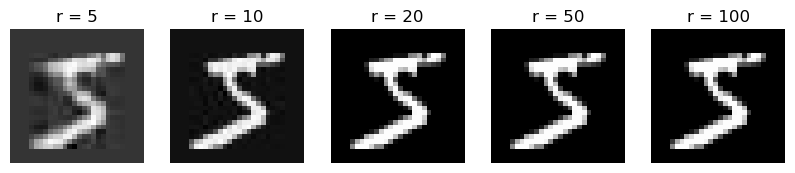

In [170]:
visualize_svd(train['x'][0])

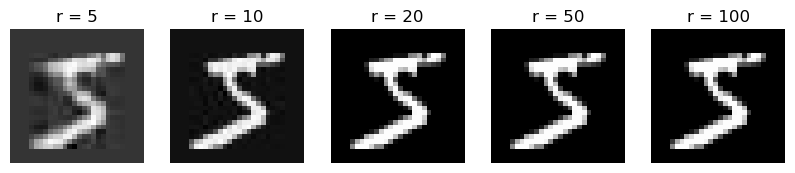

5


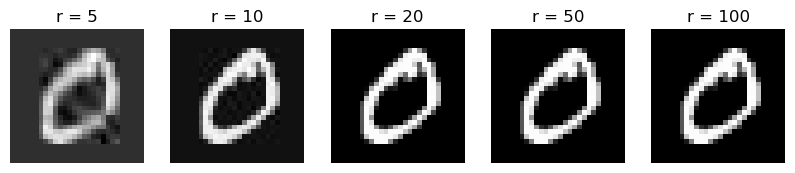

0


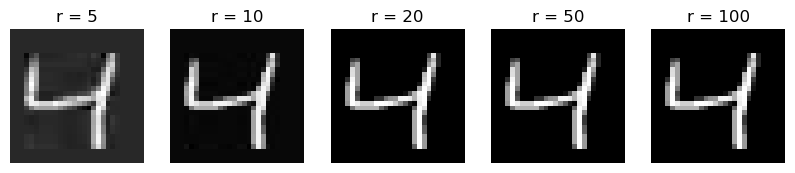

4


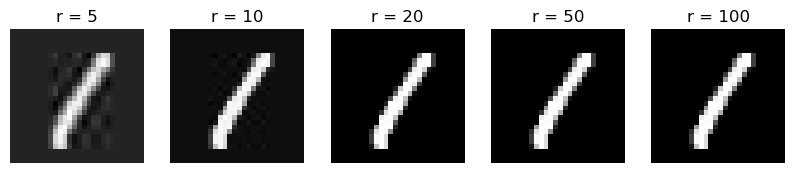

1


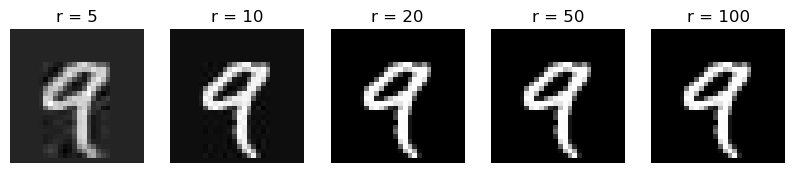

9


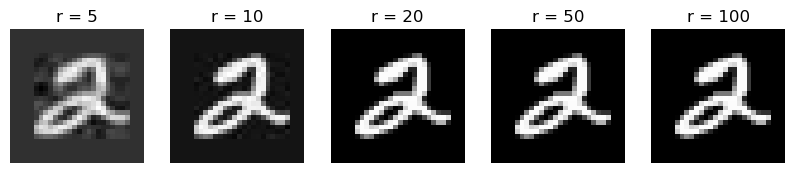

2


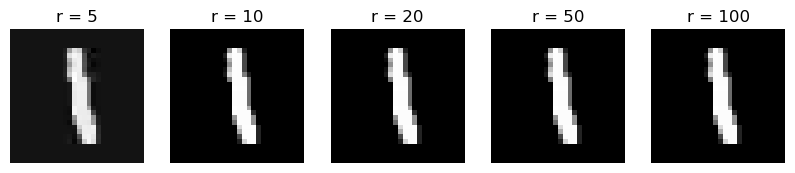

1


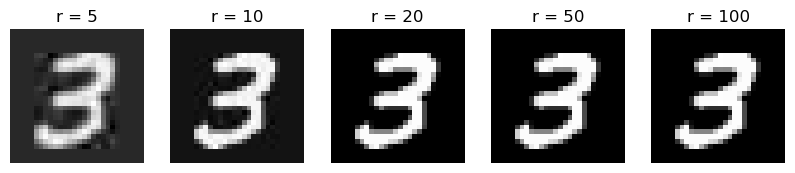

3


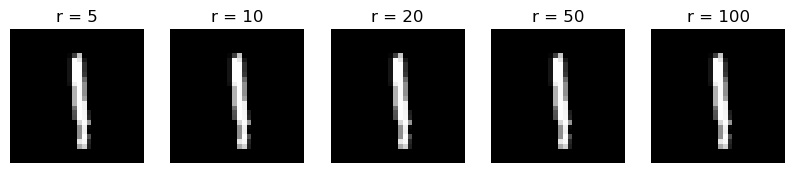

1


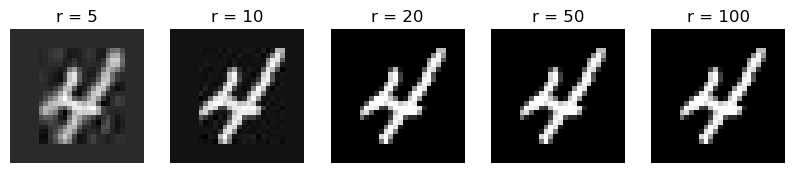

4


In [166]:
#Example image
for i in range(0,10):
    visualize_svd(train['x'][i])
    print(train_labels[i])


In [229]:
# Compute SVD for each digit
def compute_svd_per_digit(images, labels, r):
    svd_dict = {}
    for digit in range(10):  # digits 0-9
        class_images = images[labels == digit]  #Select images of this digit
        U, Sigma, Vt = svd(class_images.T, full_matrices=False)
        svd_dict[digit] = U[:, :r]  # Store top-r left singular vectors
    return svd_dict

# Project an image onto the subspace spanned by top-r left singular vectors
def compute_residual(image, U_r):
    """Computes the residual of the SVD matrix, distance of the image to the subspace it is spanned on (with rank r)"""
    projection = U_r @ (U_r.T @ image)
    residual = np.linalg.norm(image - projection) / np.linalg.norm(image)
    return residual

# Classify an image using the smallest residual
def classify_image(image, svd_dict):
    ''''''
    residuals = {digit: compute_residual(image, U_r) for digit, U_r in svd_dict.items()}
    return min(residuals, key=residuals.get)  # Return digit with smallest residual

# Prepare the dataset
accuracy_list = []
array_t1 = []
array_t2 =[]
for i in range (10,40):#Finding the optimum r

    r = i  
    X_train = train['x']  # Training images
    y_train = train['y']  # Training labels

    X_test = test['x']  # Test images
    y_test = test['y']  # Test labels
    
# Compute SVD for each class, digits from 0-9
    start_time_1 = time.perf_counter()
    svd_dict = compute_svd_per_digit(X_train, y_train, r)
    end_time_1 = time.perf_counter()
    
    time_1 = end_time_1 - start_time_1
    array_t1.append(time_1)
    print(time_1)
# Classify test images
    start_time_2 = time.perf_counter()
    predictions = np.array([classify_image(image, svd_dict) for image in X_test])
    accuracy = np.mean(predictions == y_test)
    end_time_2 = time.perf_counter()
    time_2 = end_time_2 - start_time_2
    array_t2.append(time_2)
    print(time_2)
    
    accuracy_list.append(accuracy)
    
    print(f"Accuracy: {accuracy} with rank:{r}")

    
    

15.09515191684477
1.312029958004132
Accuracy: 0.9485 with rank:10
13.136472291778773
1.3329438751097769
Accuracy: 0.9493 with rank:11
20.61709608300589
4.870964749949053
Accuracy: 0.9489 with rank:12
14.35991929192096
3.3846789579838514
Accuracy: 0.9498 with rank:13
15.935886457795277
3.665656042052433
Accuracy: 0.9509 with rank:14
13.332040040986612
8.875301541993394
Accuracy: 0.9527 with rank:15
15.24680733284913
3.543832709081471
Accuracy: 0.9524 with rank:16
14.126399166183546
4.319532500114292
Accuracy: 0.9539 with rank:17
23.62267425004393
3.727035125019029
Accuracy: 0.9556 with rank:18
12.926196957938373
4.6199087500572205
Accuracy: 0.9563 with rank:19
14.204543750034645
3.848722541006282
Accuracy: 0.9573 with rank:20
13.496008000103757
5.45731558278203
Accuracy: 0.9573 with rank:21
18.567520499927923
6.038217541063204
Accuracy: 0.9568 with rank:22
25.017082625068724
10.165595208993182
Accuracy: 0.9585 with rank:23
38.992822708096355
9.170468667056412
Accuracy: 0.9578 with rank:

Text(0, 0.5, 'Accuracy')

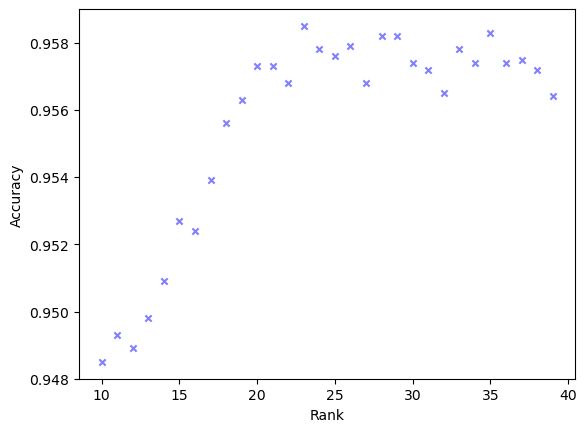

In [221]:
accuracy_list
rank= []
for r in range (10,40):
    rank.append(r)

x= np.array(rank)
y= np.array(accuracy_list)
plt.scatter(x, y, color='blue', alpha=0.5, s = 20,marker = 'x')
plt.xlabel('Rank')
plt.ylabel('Accuracy')


In [222]:
accuracy_list.index(max(accuracy_list))
index = accuracy_list.index(max(accuracy_list))+10

In [224]:
index

23

In [201]:
r = 10  
X_train = train['x']  # Training images
y_train = train['y']  # Training labels

X_test = test['x']  # Test images
y_test = test['y']  # Test labels

# Compute SVD for each class
svd_dict = compute_svd_per_digit(X_train, y_train, r)

# Classify test images
predictions = np.array([classify_image(image, svd_dict) for image in X_test])
accuracy = np.mean(predictions == y_test)
accuracy_list.append(accuracy)
print(f"Accuracy: {accuracy} with rank:{r}")

Accuracy: 0.9485 with rank:10
